In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import imageio
import random
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [2]:
#If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory = r'/content/drive/Shareddrives/cancer-detection-model/MERGED-REVISED The IQ-OTHNCCD lung cancer dataset'
else:
    #    If you want to run local
    print('Not running on CoLab')
    directory = r'../../data/cancer-detection-model/MERGED-REVISED The IQ-OTHNCCD lung cancer dataset'

categories =['Bengin cases', 'Malignant cases', 'Normal cases']

Not running on CoLab


'C:\\Users\\thayes\\omdena\\myanmar-chapter-chest-x-rays\\src\\visualizations\\cancer-detection-model'

## Check access to data

Bengin cases


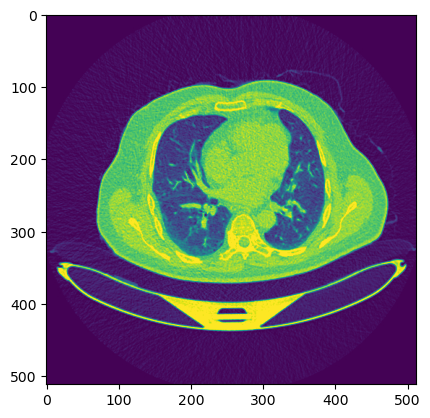

Malignant cases


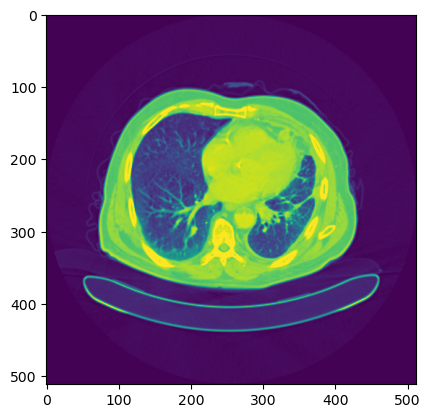

Normal cases


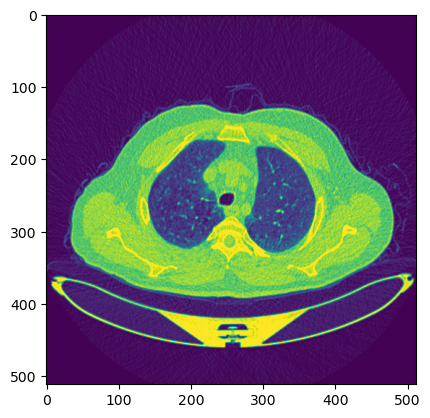

In [3]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

In [4]:
for i in categories:
  path = os.path.join(directory, i)
  file_list = os.listdir(path)
  print(len(file_list))

120
1085
577


## Preprocess the data

In [5]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

In [6]:
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

X length: 1782
y counts: Counter({1: 1085, 2: 577, 0: 120})


In [7]:
# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.3)

In [9]:
print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

1247 (1247, 256, 256, 1)
535 (535, 256, 256, 1)


## Apply SMOTE to oversample the data

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

1247 (1247, 256, 256, 1)
1247 (1247, 65536)


In [12]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 752, 2: 405, 0: 90})
After SMOTE: Counter({1: 752, 2: 752, 0: 752})


In [13]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

1247 (1247, 256, 256, 1)
2256 (2256, 256, 256, 1)


## Mini-Resnet model

In [14]:
import tensorflow as tf
tf.random.set_seed(42)
import keras

In [15]:
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalCrossentropy

In [16]:
# convert to rgb images
X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_sampled))
X_valid_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_valid))

print(len(X_train_sampled), X_train_sampled.shape)
print(len(X_train_rgb), X_train_rgb.shape)

2256 (2256, 256, 256, 1)
2256 (2256, 256, 256, 3)


### Mini-Resnet

In [17]:
class IdentityBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(IdentityBlock, self).__init__(name='')
    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.act = tf.keras.layers.Activation('relu')
    self.add = tf.keras.layers.Add()

  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.act(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.add([x, input_tensor])
    x = self.act(x)
    return x

In [18]:
class Mini_ResNet(tf.keras.Model):
  def __init__(self):
    super(Mini_ResNet, self).__init__()
    self.conv = tf.keras.layers.Conv2D(64, 5, padding='same')
    self.bn = tf.keras.layers.BatchNormalization()
    self.act = tf.keras.layers.Activation('relu')
    self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.id1a = IdentityBlock(64,3)
    self.id1b = IdentityBlock(64,3)
    self.global_pool = tf.keras.layers.GlobalMaxPooling2D()
    self.classifier = tf.keras.layers.Dense(3, activation='softmax')

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.bn(x)
    x = self.act(x)
    x = self.max_pool(x)
    x = self.id1a(x)
    x = self.id1b(x)
    x = self.global_pool(x)
    return self.classifier(x)

In [19]:
model_2 = Mini_ResNet()
model_2.compile(
    # optimizer = 'adam'
    optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.001, momentum=0.8),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [20]:
checkpointer = ModelCheckpoint(filepath='lung_cancer_detection.mini_resnet',
                            monitor='val_accuracy', verbose = 1,
                            save_best_only=True)

In [21]:
r = model_2.fit(X_train_rgb, y_train_sampled, batch_size=32, epochs=20, validation_data=(X_valid_rgb, y_valid),
               callbacks=[checkpointer])

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.3063 - accuracy: 0.6161
Epoch 1: val_accuracy improved from -inf to 0.52897, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 334s 5s/step - loss: 1.3063 - accuracy: 0.6161 - val_loss: 1.0951 - val_accuracy: 0.5290
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.8431
Epoch 2: val_accuracy did not improve from 0.52897
71/71 [==============================] - 316s 4s/step - loss: 0.4193 - accuracy: 0.8431 - val_loss: 1.3226 - val_accuracy: 0.3907
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.9136
Epoch 3: val_accuracy did not improve from 0.52897
71/71 [==============================] - 312s 4s/step - loss: 0.2633 - accuracy: 0.9136 - val_loss: 1.4719 - val_accuracy: 0.4280
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9566
Epoch 4: val_accuracy improved from 0.52897 to 0.64860, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 315s 4s/step - loss: 0.1592 - accuracy: 0.9566 - val_loss: 1.2213 - val_accuracy: 0.6486
Epoch 5/20
71/71 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9499
Epoch 5: val_accuracy improved from 0.64860 to 0.66168, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 315s 4s/step - loss: 0.1552 - accuracy: 0.9499 - val_loss: 1.1852 - val_accuracy: 0.6617
Epoch 6/20
71/71 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9756
Epoch 6: val_accuracy improved from 0.66168 to 0.72710, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 323s 5s/step - loss: 0.0935 - accuracy: 0.9756 - val_loss: 0.5994 - val_accuracy: 0.7271
Epoch 7/20
71/71 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9836
Epoch 7: val_accuracy improved from 0.72710 to 0.86729, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 324s 5s/step - loss: 0.0726 - accuracy: 0.9836 - val_loss: 0.3215 - val_accuracy: 0.8673
Epoch 8/20
71/71 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9863
Epoch 8: val_accuracy improved from 0.86729 to 0.87103, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 329s 5s/step - loss: 0.0591 - accuracy: 0.9863 - val_loss: 0.2883 - val_accuracy: 0.8710
Epoch 9/20
71/71 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9938
Epoch 9: val_accuracy improved from 0.87103 to 0.98692, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 320s 5s/step - loss: 0.0383 - accuracy: 0.9938 - val_loss: 0.0568 - val_accuracy: 0.9869
Epoch 10/20
71/71 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9925
Epoch 10: val_accuracy did not improve from 0.98692
71/71 [==============================] - 322s 5s/step - loss: 0.0413 - accuracy: 0.9925 - val_loss: 0.0530 - val_accuracy: 0.9832
Epoch 11/20
71/71 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9982
Epoch 11: val_accuracy did not improve from 0.98692
71/71 [==============================] - 320s 5s/step - loss: 0.0212 - accuracy: 0.9982 - val_loss: 0.0947 - val_accuracy: 0.9664
Epoch 12/20
71/71 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9965
Epoch 12: val_accuracy did not improve from 0.98692
71/71 [==============================] - 320s 5s/step - loss: 0.0250 - accuracy: 0.9965 - val_loss: 0.0677 - val_accuracy: 0.9720
Epoch 13/20
71/71 [====================

INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 322s 5s/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9888
Epoch 14/20
71/71 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9996
Epoch 14: val_accuracy improved from 0.98879 to 0.99626, saving model to lung_cancer_detection.mini_resnet


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


INFO:tensorflow:Assets written to: lung_cancer_detection.mini_resnet\assets


71/71 [==============================] - 322s 5s/step - loss: 0.0117 - accuracy: 0.9996 - val_loss: 0.0313 - val_accuracy: 0.9963
Epoch 15/20
71/71 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9996
Epoch 15: val_accuracy did not improve from 0.99626
71/71 [==============================] - 327s 5s/step - loss: 0.0109 - accuracy: 0.9996 - val_loss: 0.0316 - val_accuracy: 0.9963
Epoch 16/20
71/71 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9996
Epoch 16: val_accuracy did not improve from 0.99626
71/71 [==============================] - 327s 5s/step - loss: 0.0103 - accuracy: 0.9996 - val_loss: 0.0230 - val_accuracy: 0.9944
Epoch 17/20
71/71 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9991
Epoch 17: val_accuracy did not improve from 0.99626
71/71 [==============================] - 330s 5s/step - loss: 0.0081 - accuracy: 0.9991 - val_loss: 0.0238 - val_accuracy: 0.9925
Epoch 18/20
71/71 [====================

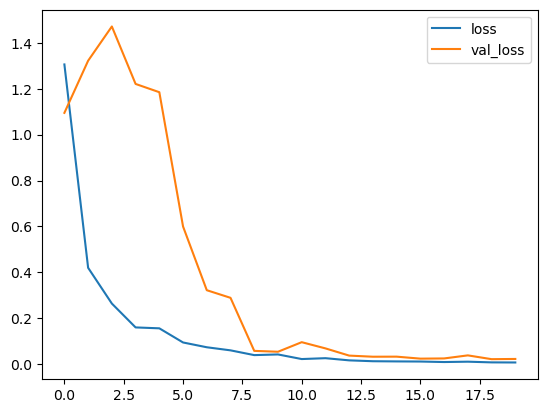

In [22]:
# plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

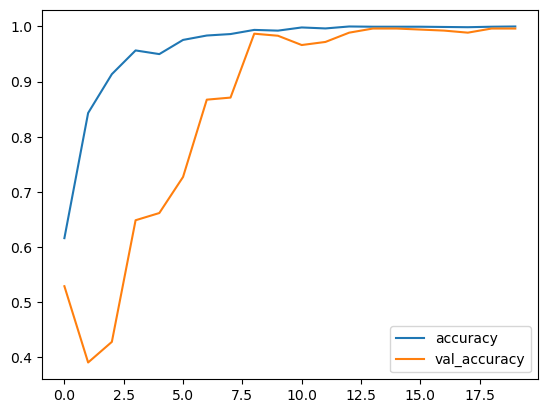

In [23]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [24]:
# !mkdir -p saved_model
# model_2.save('saved_model/my_model_2')

In [25]:
new_model_2 = tf.keras.models.load_model('lung_cancer_detection.mini_resnet')

In [26]:
new_model_2.summary()

Model: "mini__res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  4864      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
  (IdentityBlock)            multiple                  74368     
                                                                 
  (IdentityBlock)            multiple                

## Prepare test data

In [31]:
#If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory_2 = r'/content/drive/Shareddrives/cancer-detection-model/TEST lung cancer dataset'
else:
    #    If you want to run local
    print('Not running on CoLab')
    directory_2 = r'../../data/cancer-detection-model/TEST lung cancer dataset'

categories =['Benign cases', 'Malignant cases', 'Normal cases']

Not running on CoLab


In [32]:
for i in categories:
  path = os.path.join(directory_2, i)
  file_list = os.listdir(path)
  print(len(file_list))

1
261
54


In [35]:
test_data = []
img_size = 256

for i in categories:
    path = os.path.join(directory_2, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        
        if (filepath.endswith('.jpg') or filepath.endswith('.png')):
            img = cv2.imread(filepath, 0)
            # preprocess here
            img = cv2.resize(img, (img_size, img_size))
            test_data.append([img, class_num])

In [36]:
len(test_data)

315

In [37]:
X_test, y_test = [], []
for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

print('X_test length:', len(X_test))
print('y_test length:', len(y_test))

X_test length: 315
y_test length: 315


In [38]:
# normalize
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0
y_test = np.array(y_test)

In [39]:
X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))

## Model evaluation

In [40]:
y_pred = new_model_2.predict(X_test_rgb)

10/10 [==============================] - 9s 798ms/step


In [41]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [42]:
accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9968253968253968


In [43]:
precision = precision_score(y_test, y_pred_classes)
print("Test Precision:", precision)

Test Precision: 0.9961832061068703


In [44]:
recall = recall_score(y_test, y_pred_classes)
print("Test Recall:", recall)

Test Recall: 1.0


In [45]:
cm = confusion_matrix(y_test, y_pred_classes, labels=[1,2])
cm

array([[261,   0],
       [  1,  53]], dtype=int64)

## Try the luna16 dataset

In [48]:
#If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory_3 = r'/content/drive/Shareddrives/cancer-detection-model/luna16-jpg for testing'
else:
    #    If you want to run local
    print('Not running on CoLab')
    directory_3 = r'../../data/cancer-detection-model/luna16-jpg for testing'

categories =['Benign', 'Malignant', 'Normal']

Not running on CoLab


In [49]:
for i in categories:
  path = os.path.join(directory_3, i)
  file_list = os.listdir(path)
  print(len(file_list))

0
817
3921


In [50]:
test_data = []
img_size = 256

for i in categories:
    path = os.path.join(directory_3, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        
        if (filepath.endswith('.jpg') or filepath.endswith('.png')):
            img = cv2.imread(filepath, 0)
            # preprocess here
            img = cv2.resize(img, (img_size, img_size))
            test_data.append([img, class_num])

In [51]:
len(test_data)

4738

In [52]:
# normalize
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0
y_test = np.array(y_test)

In [53]:
X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))

### Model Evaluation

In [54]:
y_pred = new_model_2.predict(X_test_rgb)

10/10 [==============================] - 8s 792ms/step


In [55]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [57]:
accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8285714285714286


In [56]:
cm = confusion_matrix(y_test, y_pred_classes, labels=[1,2])
cm

array([[261,   0],
       [ 54,   0]], dtype=int64)